<a href="https://colab.research.google.com/github/zhuzz12/cvdl/blob/main/CV_W11_GAN_60ep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

In [ ]:
!unzip "/content/archive.zip" -d "/content/catcat/"

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /content/catcat/cats/cats/5499.jpg  
  inflating: /content/catcat/cats/cats/55.jpg  
  inflating: /content/catcat/cats/cats/550.jpg  
  inflating: /content/catcat/cats/cats/5500.jpg  
  inflating: /content/catcat/cats/cats/5501.jpg  
  inflating: /content/catcat/cats/cats/5502.jpg  
  inflating: /content/catcat/cats/cats/5503.jpg  
  inflating: /content/catcat/cats/cats/5504.jpg  
  inflating: /content/catcat/cats/cats/5505.jpg  
  inflating: /content/catcat/cats/cats/5506.jpg  
  inflating: /content/catcat/cats/cats/5507.jpg  
  inflating: /content/catcat/cats/cats/5508.jpg  
  inflating: /content/catcat/cats/cats/5509.jpg  
  inflating: /content/catcat/cats/cats/551.jpg  
  inflating: /content/catcat/cats/cats/5510.jpg  
  inflating: /content/catcat/cats/cats/5511.jpg  
  inflating: /content/catcat/cats/cats/5512.jpg  
  inflating: /content/catcat/cats/cats/5513.jpg  
  inflating: /content/catcat/cats/ca

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#DATA_DIR = '/content/drive/MyDrive/catcat'
#https://drive.google.com/drive/folders/1YKxRaUp_zDXGX4UcgjfIK_1rqvS6mrf6?usp=share_link
DATA_DIR = '/content/catcat/cats'

In [ ]:
from PIL import Image
from pathlib import Path
for p in Path(DATA_DIR+'/cats').glob('*.jpg'):
  try:
    im = Image.open(p)
    im2 = im.convert('RGB')
  except OSError:
    print("Cannot load : {}".format(p))


In [ ]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [ ]:
print(len(train_dl))

124


In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

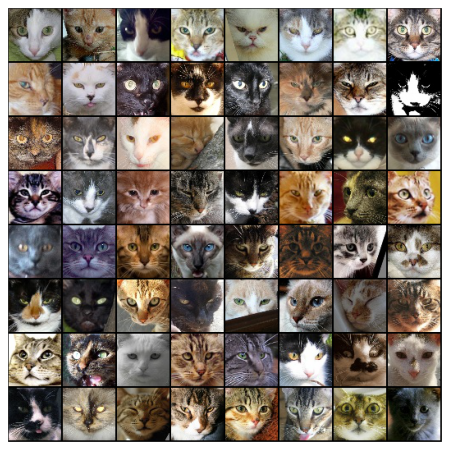

In [ ]:
show_batch(train_dl)

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:

discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 128

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


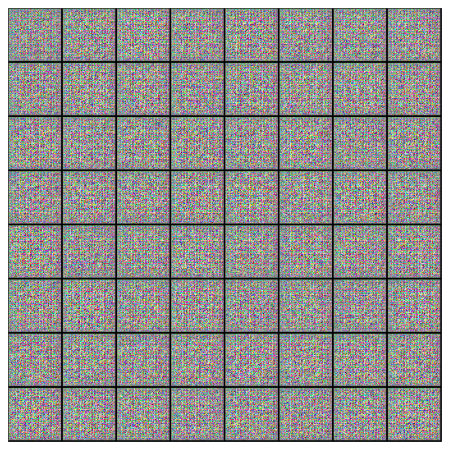

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) 
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
    
        # Save generated images
        #if epoch == epochs - 1:
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}
lr = 0.0002
epochs = 60

In [ ]:
history = fit(model, criterion, epochs, lr)

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [1/60], loss_g: 7.9064, loss_d: 0.3353, real_score: 0.8840, fake_score: 0.1177
Saving generated-images-0001.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [2/60], loss_g: 4.1981, loss_d: 0.6229, real_score: 0.7939, fake_score: 0.1898
Saving generated-images-0002.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [3/60], loss_g: 3.4565, loss_d: 0.8007, real_score: 0.7435, fake_score: 0.2673
Saving generated-images-0003.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [4/60], loss_g: 3.8260, loss_d: 0.7723, real_score: 0.7413, fake_score: 0.2553
Saving generated-images-0004.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [5/60], loss_g: 4.1849, loss_d: 0.7403, real_score: 0.7547, fake_score: 0.2400
Saving generated-images-0005.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [6/60], loss_g: 4.4005, loss_d: 0.7109, real_score: 0.7654, fake_score: 0.2338
Saving generated-images-0006.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [7/60], loss_g: 4.6737, loss_d: 0.7394, real_score: 0.7659, fake_score: 0.2356
Saving generated-images-0007.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [8/60], loss_g: 4.5910, loss_d: 0.6570, real_score: 0.7769, fake_score: 0.2214
Saving generated-images-0008.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [9/60], loss_g: 4.5603, loss_d: 0.7098, real_score: 0.7686, fake_score: 0.2289
Saving generated-images-0009.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [10/60], loss_g: 4.5072, loss_d: 0.6838, real_score: 0.7815, fake_score: 0.2208
Saving generated-images-0010.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [11/60], loss_g: 4.4198, loss_d: 0.7090, real_score: 0.7761, fake_score: 0.2197
Saving generated-images-0011.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [12/60], loss_g: 4.0873, loss_d: 0.6534, real_score: 0.7885, fake_score: 0.2097
Saving generated-images-0012.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [13/60], loss_g: 4.5004, loss_d: 0.5962, real_score: 0.8014, fake_score: 0.1988
Saving generated-images-0013.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [14/60], loss_g: 4.3701, loss_d: 0.6427, real_score: 0.7977, fake_score: 0.2004
Saving generated-images-0014.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [15/60], loss_g: 4.3609, loss_d: 0.6259, real_score: 0.7989, fake_score: 0.1931
Saving generated-images-0015.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [16/60], loss_g: 4.1958, loss_d: 0.5519, real_score: 0.8159, fake_score: 0.1911
Saving generated-images-0016.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [17/60], loss_g: 4.2524, loss_d: 0.5898, real_score: 0.8126, fake_score: 0.1840
Saving generated-images-0017.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [18/60], loss_g: 4.2896, loss_d: 0.5647, real_score: 0.8190, fake_score: 0.1814
Saving generated-images-0018.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [19/60], loss_g: 4.4673, loss_d: 0.5385, real_score: 0.8309, fake_score: 0.1690
Saving generated-images-0019.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [20/60], loss_g: 4.1786, loss_d: 0.5662, real_score: 0.8189, fake_score: 0.1781
Saving generated-images-0020.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [21/60], loss_g: 4.4092, loss_d: 0.5133, real_score: 0.8355, fake_score: 0.1683
Saving generated-images-0021.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [22/60], loss_g: 4.4121, loss_d: 0.4737, real_score: 0.8400, fake_score: 0.1522
Saving generated-images-0022.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [23/60], loss_g: 4.7145, loss_d: 0.4596, real_score: 0.8497, fake_score: 0.1512
Saving generated-images-0023.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [24/60], loss_g: 4.7005, loss_d: 0.4682, real_score: 0.8452, fake_score: 0.1556
Saving generated-images-0024.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [25/60], loss_g: 4.7911, loss_d: 0.4288, real_score: 0.8593, fake_score: 0.1388
Saving generated-images-0025.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [26/60], loss_g: 4.5558, loss_d: 0.4790, real_score: 0.8491, fake_score: 0.1494
Saving generated-images-0026.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [27/60], loss_g: 4.6871, loss_d: 0.4623, real_score: 0.8547, fake_score: 0.1394
Saving generated-images-0027.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [28/60], loss_g: 4.2913, loss_d: 0.4514, real_score: 0.8495, fake_score: 0.1534
Saving generated-images-0028.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [29/60], loss_g: 4.8832, loss_d: 0.4093, real_score: 0.8664, fake_score: 0.1357
Saving generated-images-0029.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [30/60], loss_g: 4.6064, loss_d: 0.4590, real_score: 0.8614, fake_score: 0.1293
Saving generated-images-0030.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [31/60], loss_g: 4.5711, loss_d: 0.4769, real_score: 0.8534, fake_score: 0.1545
Saving generated-images-0031.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [32/60], loss_g: 4.8732, loss_d: 0.3712, real_score: 0.8759, fake_score: 0.1240
Saving generated-images-0032.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [33/60], loss_g: 4.5776, loss_d: 0.4272, real_score: 0.8649, fake_score: 0.1300
Saving generated-images-0033.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [34/60], loss_g: 4.9146, loss_d: 0.3964, real_score: 0.8798, fake_score: 0.1197
Saving generated-images-0034.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [35/60], loss_g: 4.8837, loss_d: 0.3336, real_score: 0.8850, fake_score: 0.1144
Saving generated-images-0035.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [36/60], loss_g: 5.0988, loss_d: 0.3344, real_score: 0.8883, fake_score: 0.1094
Saving generated-images-0036.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [37/60], loss_g: 5.0525, loss_d: 0.3476, real_score: 0.8890, fake_score: 0.1079
Saving generated-images-0037.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [38/60], loss_g: 5.2919, loss_d: 0.4101, real_score: 0.8735, fake_score: 0.1264
Saving generated-images-0038.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [39/60], loss_g: 5.0591, loss_d: 0.4550, real_score: 0.8672, fake_score: 0.1312
Saving generated-images-0039.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [40/60], loss_g: 5.3271, loss_d: 0.3247, real_score: 0.8931, fake_score: 0.1116
Saving generated-images-0040.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [41/60], loss_g: 5.2380, loss_d: 0.3785, real_score: 0.8831, fake_score: 0.1123
Saving generated-images-0041.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [42/60], loss_g: 4.9960, loss_d: 0.3458, real_score: 0.8862, fake_score: 0.1133
Saving generated-images-0042.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [43/60], loss_g: 5.5173, loss_d: 0.3722, real_score: 0.8877, fake_score: 0.1106
Saving generated-images-0043.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [44/60], loss_g: 5.4042, loss_d: 0.3001, real_score: 0.9026, fake_score: 0.1024
Saving generated-images-0044.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [45/60], loss_g: 5.7787, loss_d: 0.3120, real_score: 0.8985, fake_score: 0.0971
Saving generated-images-0045.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [46/60], loss_g: 5.3069, loss_d: 0.2611, real_score: 0.9118, fake_score: 0.0913
Saving generated-images-0046.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [47/60], loss_g: 5.5522, loss_d: 0.2971, real_score: 0.9086, fake_score: 0.0905
Saving generated-images-0047.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [48/60], loss_g: 5.6177, loss_d: 0.2252, real_score: 0.9208, fake_score: 0.0751
Saving generated-images-0048.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [49/60], loss_g: 5.6881, loss_d: 0.2650, real_score: 0.9144, fake_score: 0.0865
Saving generated-images-0049.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [50/60], loss_g: 6.1905, loss_d: 0.2221, real_score: 0.9285, fake_score: 0.0748
Saving generated-images-0050.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [51/60], loss_g: 5.9886, loss_d: 0.1724, real_score: 0.9365, fake_score: 0.0650
Saving generated-images-0051.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [52/60], loss_g: 6.1401, loss_d: 0.1989, real_score: 0.9324, fake_score: 0.0662
Saving generated-images-0052.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [53/60], loss_g: 6.1496, loss_d: 0.3214, real_score: 0.9059, fake_score: 0.0877
Saving generated-images-0053.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [54/60], loss_g: 4.9409, loss_d: 0.3916, real_score: 0.8830, fake_score: 0.1204
Saving generated-images-0054.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [55/60], loss_g: 5.4889, loss_d: 0.2178, real_score: 0.9262, fake_score: 0.0761
Saving generated-images-0055.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [56/60], loss_g: 5.9212, loss_d: 0.3153, real_score: 0.9137, fake_score: 0.0866
Saving generated-images-0056.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [57/60], loss_g: 6.1936, loss_d: 0.2012, real_score: 0.9296, fake_score: 0.0683
Saving generated-images-0057.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [58/60], loss_g: 5.8190, loss_d: 0.3490, real_score: 0.8993, fake_score: 0.1005
Saving generated-images-0058.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [59/60], loss_g: 5.7556, loss_d: 0.2190, real_score: 0.9229, fake_score: 0.0744
Saving generated-images-0059.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [60/60], loss_g: 5.8497, loss_d: 0.1400, real_score: 0.9477, fake_score: 0.0523
Saving generated-images-0060.png


In [ ]:
save_samples(epochs, fixed_latent, show=False)

Saving generated-images-0060.png


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

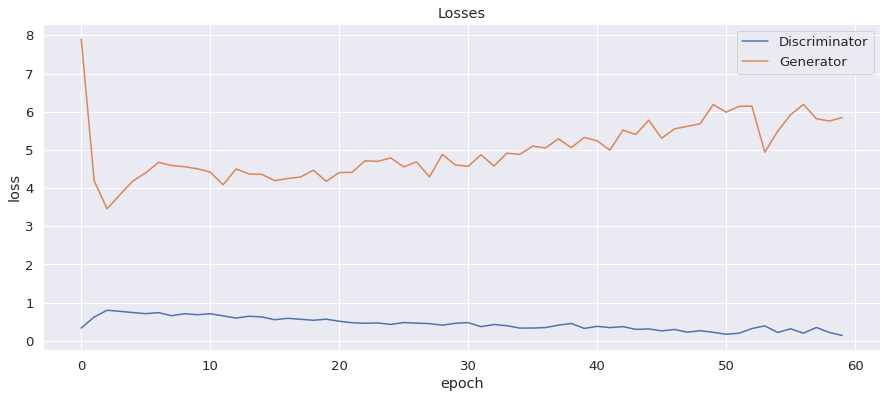

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

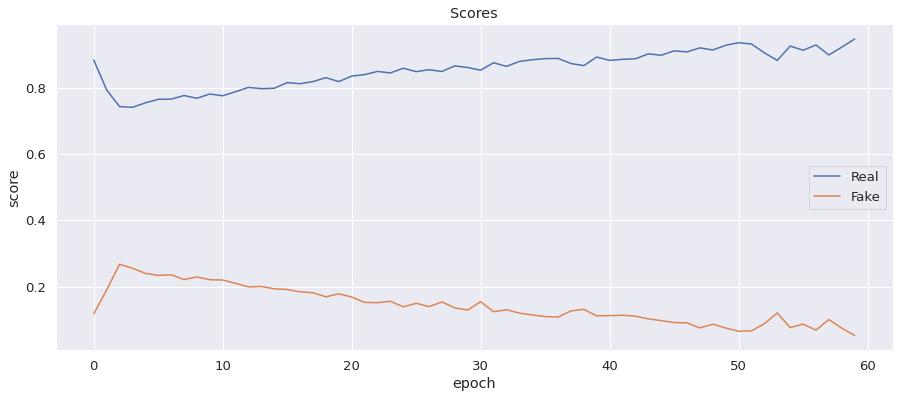

In [ ]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [ ]:
from google.colab.patches import cv2_imshow
import cv2

Epoch10: 


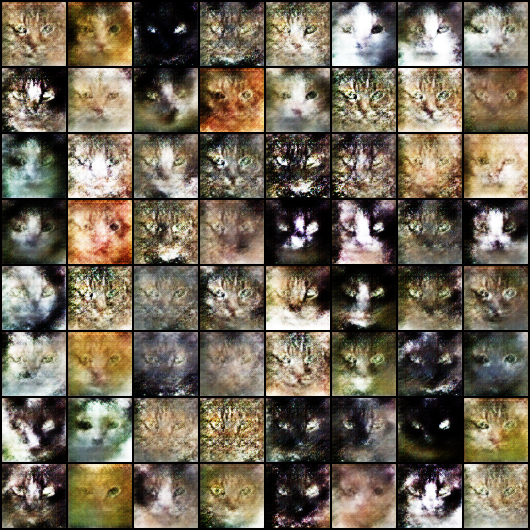

Epoch20: 


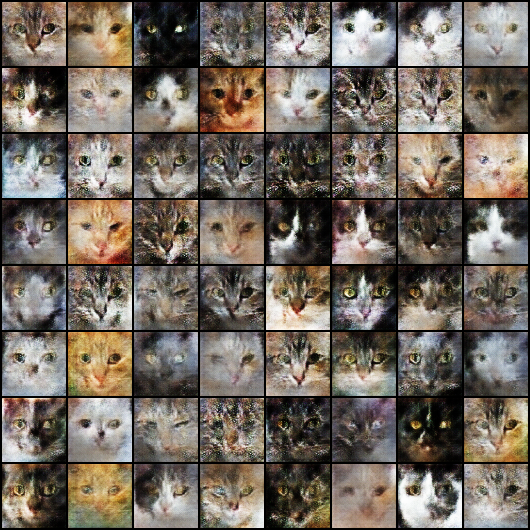

Epoch30: 


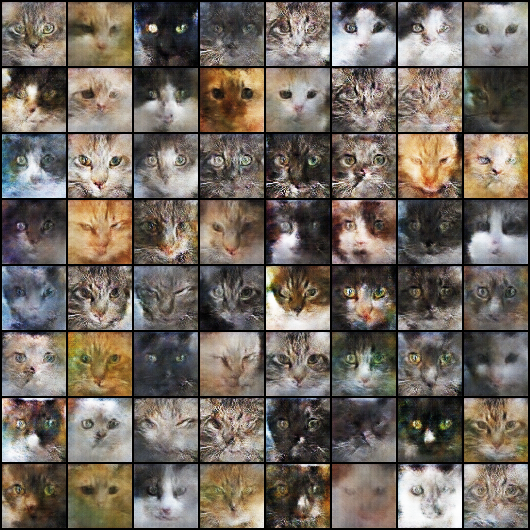

Epoch40: 


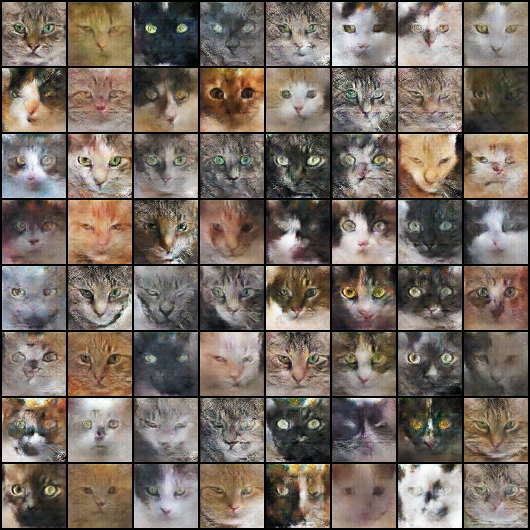

Epoch50: 


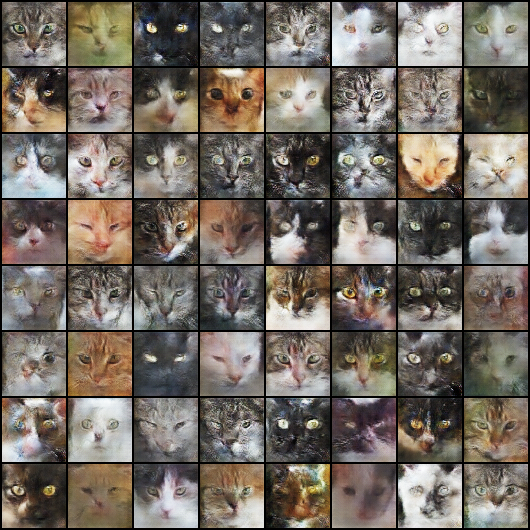

Epoch60: 


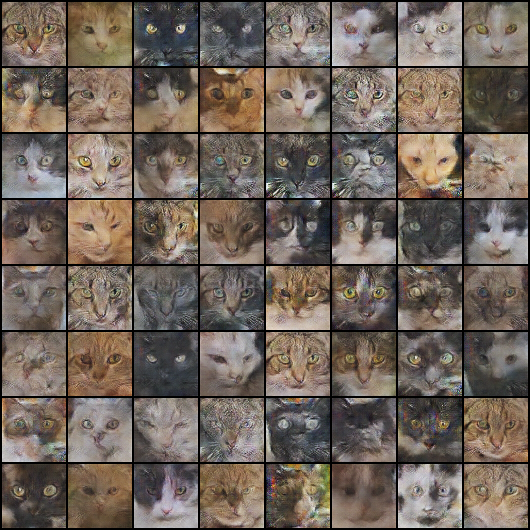

In [ ]:
print("Epoch10: ")
img = cv2.imread('/content/generated/generated-images-0010.png')
cv2_imshow(img)

print("Epoch20: ")
img = cv2.imread('/content/generated/generated-images-0020.png')
cv2_imshow(img)

print("Epoch30: ")
img = cv2.imread('/content/generated/generated-images-0030.png')
cv2_imshow(img)

print("Epoch40: ")
img = cv2.imread('/content/generated/generated-images-0040.png')
cv2_imshow(img)

print("Epoch50: ")
img = cv2.imread('/content/generated/generated-images-0050.png')
cv2_imshow(img)


print("Epoch60: ")
img = cv2.imread('/content/generated/generated-images-0060.png')
cv2_imshow(img)
